In [1]:
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import numpy as np
plt.style.use('seaborn-talk')


# Source for the data
US Census at School - https://ww2.amstat.org/censusatschool/randomsampleform.cfm 
    
Random sample of anonymized students and teachers in American schools based on selection by state, years from 2010-2018, selectable by sample size of 50-1000. 
Has features like height, language spoken, travel time to school, and text messages received.

## Question
Our business question will be - can we build estimates for homework hours per week per state? 

In [3]:
df = pd.read_csv('data/school_data_us.csv')

## Exploratory Data Analysis.
- It is instructive right now to do some exploratory Data Analysis. 
- Let's look at the first 5 columns. Just to see their names. 

In [4]:
df.columns.tolist()[:5]

['Country', 'Region', 'DataYear', 'ClassGrade', 'Gender']

In [5]:
df.describe()

,DataYear,ClassGrade,Ageyears,Languages_spoken,Travel_time_to_School,Reaction_time,Score_in_memory_game,Left_Footlength_cm,Index_Fingerlength_mm,Ring_Fingerlength_mm,...,Doing_Homework_Hours,Doing_Things_With_Family_Hours,Outdoor_Activities_Hours,Video_Games_Hours,Social_Websites_Hours,Texting_Messaging_Hours,Computer_Use_Hours,Watching_TV_Hours,Paid_Work_Hours,Work_At_Home_Hours
count,500.0,500.0,500.000000,485.000000,481.000000,467.000000,463.000000,427.000000,417.000000,420.000000,...,424.000000,424.000000,424.000000,424.000000,423.000000,422.000000,422.000000,421.000000,421.000000,418.000000
mean,2015.0,12.0,17.270000,1.545361,15.677755,1.844029,44.207866,25.625504,115.677077,240.496438,...,10.055373,10.696406,8.810248,4.879281,10.973168,14.818498,19.047289,7.244228,13.467933,4.732978
std,0.0,0.0,6.810129,0.732230,14.781961,26.773590,13.009642,16.297131,883.850924,2834.619777,...,10.252180,14.825859,11.674445,9.718439,19.792621,28.785697,32.156181,11.699104,101.856287,12.282680
min,2015.0,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,12.0,17.000000,1.000000,7.000000,0.325000,37.000000,23.000000,22.000000,24.625000,...,3.000000,3.000000,2.000000,0.000000,2.000000,2.000000,4.000000,2.000000,0.000000,1.000000
50%,2015.0,12.0,17.000000,1.000000,12.000000,0.399000,43.000000,25.000000,75.000000,72.000000,...,7.000000,5.000000,6.000000,1.000000,5.000000,5.000000,10.000000,4.000000,1.000000,2.000000
75%,2015.0,12.0,17.000000,2.000000,20.000000,0.500000,50.500000,27.000000,84.000000,85.000000,...,14.000000,10.250000,12.000000,5.000000,10.000000,15.000000,20.000000,8.000000,12.000000,5.000000
max,2015.0,12.0,167.000000,7.000000,180.000000,578.000000,99.000000,334.000000,18000.000000,56214.000000,...,90.000000,100.000000,100.000000,90.000000,160.000000,300.000000,500.000000,100.000000,2000.000000,160.000000


In [6]:
df.tail()

,Country,Region,DataYear,ClassGrade,Gender,Ageyears,Handed,Height_cm,Footlength_cm,Armspan_cm,...,Watching_TV_Hours,Paid_Work_Hours,Work_At_Home_Hours,Schoolwork_Pressure,Planned_Education_Level,Favorite_Music,Superpower,Preferred_Status,Role_Model_Type,Charity_Donation
495,USA,PA,2015,12,Male,17,Right-Handed,174,24.9,NaN,...,8.0,10.0,2.0,Some,Graduate degree,Pop,Fly,Happy,Sports person,International aid
496,USA,VA,2015,12,Male,18,Right-Handed,188,29.21,185.4,...,5.0,20.0,1.0,A lot,Some college,Country,Telepathy,Happy,Relative,Health
497,USA,SC,2015,12,Male,17,Right-Handed,179,24,179,...,7.0,0.0,7.0,Some,Graduate degree,Punk rock,Freeze time,Rich,Friend,Health
498,USA,IL,2015,12,Male,17,Right-Handed,173,26,179,...,2.0,0.0,3.0,Very little,Undergraduate degree,Heavy metal,Fly,Happy,Musician or singer,Education/Youth development
499,USA,DE,2015,12,Male,18,Right-Handed,178,10.5,68,...,2.0,0.0,3.0,A lot,Graduate degree,Rap/Hip hop,Fly,Rich,Sports person,International aid


* Hypothesis, I'm going to assume that there's some sort of state by state - effect for `Doing_Homework_Hours`. And we want to build a model for that. 

# Building a model

* We'll build a model and do it state by state. So a hierachical model. 

- To describe our approach intuitively, it is easier to talk about two other approaches we do not take:

- No pooling: Each state, is an independent experiment. Then either all states are the same, or we put some prior on each experiment, and we fit 51 different models, each using 1/51nd of the data.

- Complete pooling: We could aggregate all of the states - and then that assumes that homework policies are equal everywhere. 

The approach we do take is called *partial pooling*: we acknowledge that each state is a different experiment, while also positing that there is a distribution of homework amounts shared by all 33 experiments, parameterized by the mean (pooled_rate). The parameter κ acts like a slider between no pooling and complete pooling: when κ is 0, we ignore pooled_rate, and there is no pooling. As κ goes to infinity, we ignore the state level data, and will just report the pooled_rate. The model will estimate the most likely value for κ itself. These two parameters then feed into our estimates for experiment-level fatality rates (`state_rate`).

For our modelling approach we'll use Poisson as our distribution for the likelihood - this is because homework hours per week are an integer between 1 and 30. 



In [7]:
df.head(10)

,Country,Region,DataYear,ClassGrade,Gender,Ageyears,Handed,Height_cm,Footlength_cm,Armspan_cm,...,Watching_TV_Hours,Paid_Work_Hours,Work_At_Home_Hours,Schoolwork_Pressure,Planned_Education_Level,Favorite_Music,Superpower,Preferred_Status,Role_Model_Type,Charity_Donation
0,USA,CA,2015,12,Female,16,Right-Handed,157,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USA,MI,2015,12,Female,16,Right-Handed,152,21.5,153,...,7.0,0.0,6.0,A lot,Graduate degree,Other,Invisibility,Happy,Relative,"Arts, culture, sports"
2,USA,CA,2015,12,Female,16,Left-Handed,165,24.5,165,...,1.0,0.0,1.0,A lot,Graduate degree,Jazz,Telepathy,Rich,Musician or singer,International aid
3,USA,CO,2015,12,Female,17,Right-Handed,160,23,160,...,6.0,20.0,5.0,Very little,Undergraduate degree,Country,Freeze time,Happy,Sports person,Health
4,USA,MT,2015,12,Male,17,Right-Handed,178,27,180,...,5.0,23.0,0.0,Very little,Graduate degree,Punk rock,Freeze time,Happy,Relative,"Arts, culture, sports"
5,USA,AZ,2015,12,Male,17,Right-Handed,178,27,181,...,15.0,0.0,2.0,Some,Graduate degree,Rap/Hip hop,Super strength,Healthy,Business person,International aid
6,USA,TX,2015,12,Female,16,Right-Handed,152.4,6,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,USA,CA,2015,12,Female,17,Right-Handed,162.5,26,166,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,USA,NH,2015,12,Female,17,Left-Handed,162,23,164,...,4.0,0.0,2.0,A lot,Graduate degree,Rap/Hip hop,Super strength,Happy,Relative,"Wildlife, animals"
9,USA,FL,2015,12,Female,17,Right-Handed,176.4,24.5,177.2,...,5.0,0.0,2.0,Some,Undergraduate degree,Pop,Fly,Rich,Relative,"Wildlife, animals"


In [8]:
df.Doing_Homework_Hours = pd.to_numeric(df.Doing_Homework_Hours)
df.Doing_Homework_Hours = df.Doing_Homework_Hours.fillna(0)
hours_of_homework = df['Doing_Homework_Hours'].as_matrix()

/Users/peadarcoyle/miniconda3/envs/ppp/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


We are only interested in some variables. Let us restrict our attention to `Doing_Homework_Hours` and `Region`. 

In [9]:
df_small = df[['Doing_Homework_Hours', 'Region']]

In [10]:
df_average = pd.DataFrame(df_small.groupby('Region')['Doing_Homework_Hours'].mean())

In [11]:
df_average = df_average.reset_index()

In [12]:
len(df_average.Region)

33

In [13]:
hours_of_homework = df_average.Doing_Homework_Hours.as_matrix()

/Users/peadarcoyle/miniconda3/envs/ppp/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


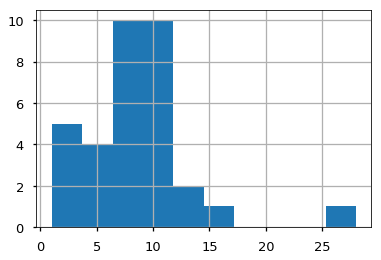

In [14]:
df_average.Doing_Homework_Hours.hist()

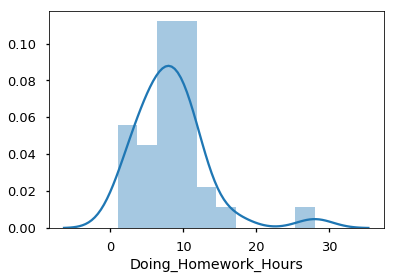

In [15]:
sns.distplot(df_average.Doing_Homework_Hours)

## First Model. 

We're going to use a modern style of bayesian workflows. 
Firstly we're going to build a poor model. Then we're going to build a better model. 

In [16]:
state = df_average.Region.values
def homework_model(hours_of_homework):
    
    with pm.Model() as model:
        pooled_rate = pm.Beta('pooled_rate', alpha=0.1, beta=1.5)
        κ_log = pm.Exponential('κ_log', lam=0.5)
        κ = pm.Deterministic('κ', tt.exp(κ_log) -1)

        state_rate = pm.Beta('state_rate', 
                             alpha=pooled_rate*κ, 
                             beta=(1-pooled_rate)*κ, 
                             shape=len(df_average.Region))
        observed_homework = pm.Poisson('y', mu=state_rate, observed=hours_of_homework)

    return model

In [17]:
model = homework_model(hours_of_homework)


- The first thing to check is are there any problems with convergence with the model. 
- We have some new features coming which will make this more obvious. 

In [19]:
print(model.check_test_point())

pooled_rate_logodds__      -2.62
state_rate_logodds__      -70.22
y                       -1109.11
κ_log_log__                -1.06
Name: Log-probability of test_point, dtype: float64


Our model will converge then. 

In [20]:
with homework_model(hours_of_homework):
    prior = pm.sample_prior_predictive()
    trace = pm.sample(10000, njobs=4, target_accept=0.90)
    posterior_predictive = pm.sample_ppc(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state_rate, κ_log, pooled_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [01:39<00:00, 422.77draws/s] 
There were 1681 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.697482940163296, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1531 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1627 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1464 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/Users/peadarcoyle/miniconda3/envs/ppp/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
100%|█████████

In [21]:
import arviz as az
data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'state': df_average.Region},
                     dims={'state_rate': ['state']})

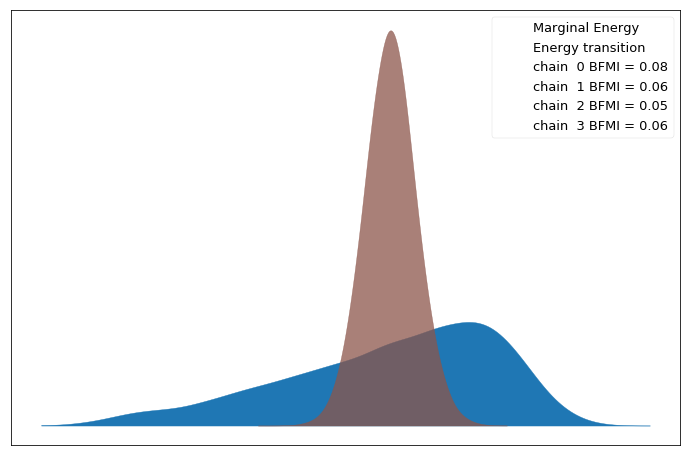

In [22]:
az.plot_energy(data, figsize=(12, 8))

The marginal energy transition should have both distributions roughly the same, this one is aweful at the tails. These distributions don't match

In [30]:
data.posterior.coords.variables

Frozen(OrderedDict([('draw', <xarray.IndexVariable 'draw' (draw: 10000)>
array([   0,    1,    2, ..., 9997, 9998, 9999])), ('chain', <xarray.IndexVariable 'chain' (chain: 4)>
array([0, 1, 2, 3])), ('state', <xarray.IndexVariable 'state' (state: 33)>
array(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'IL', 'IN',
       'KS', 'MA', 'MI', 'MN', 'MO', 'MT', 'NC', 'NH', 'NJ', 'NY', 'OH', 'OK',
       'OR', 'PA', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI'], dtype=object))]))

(<matplotlib.axes._subplots.AxesSubplot at 0x1c42d94c50>, GridSpec(4, 4))

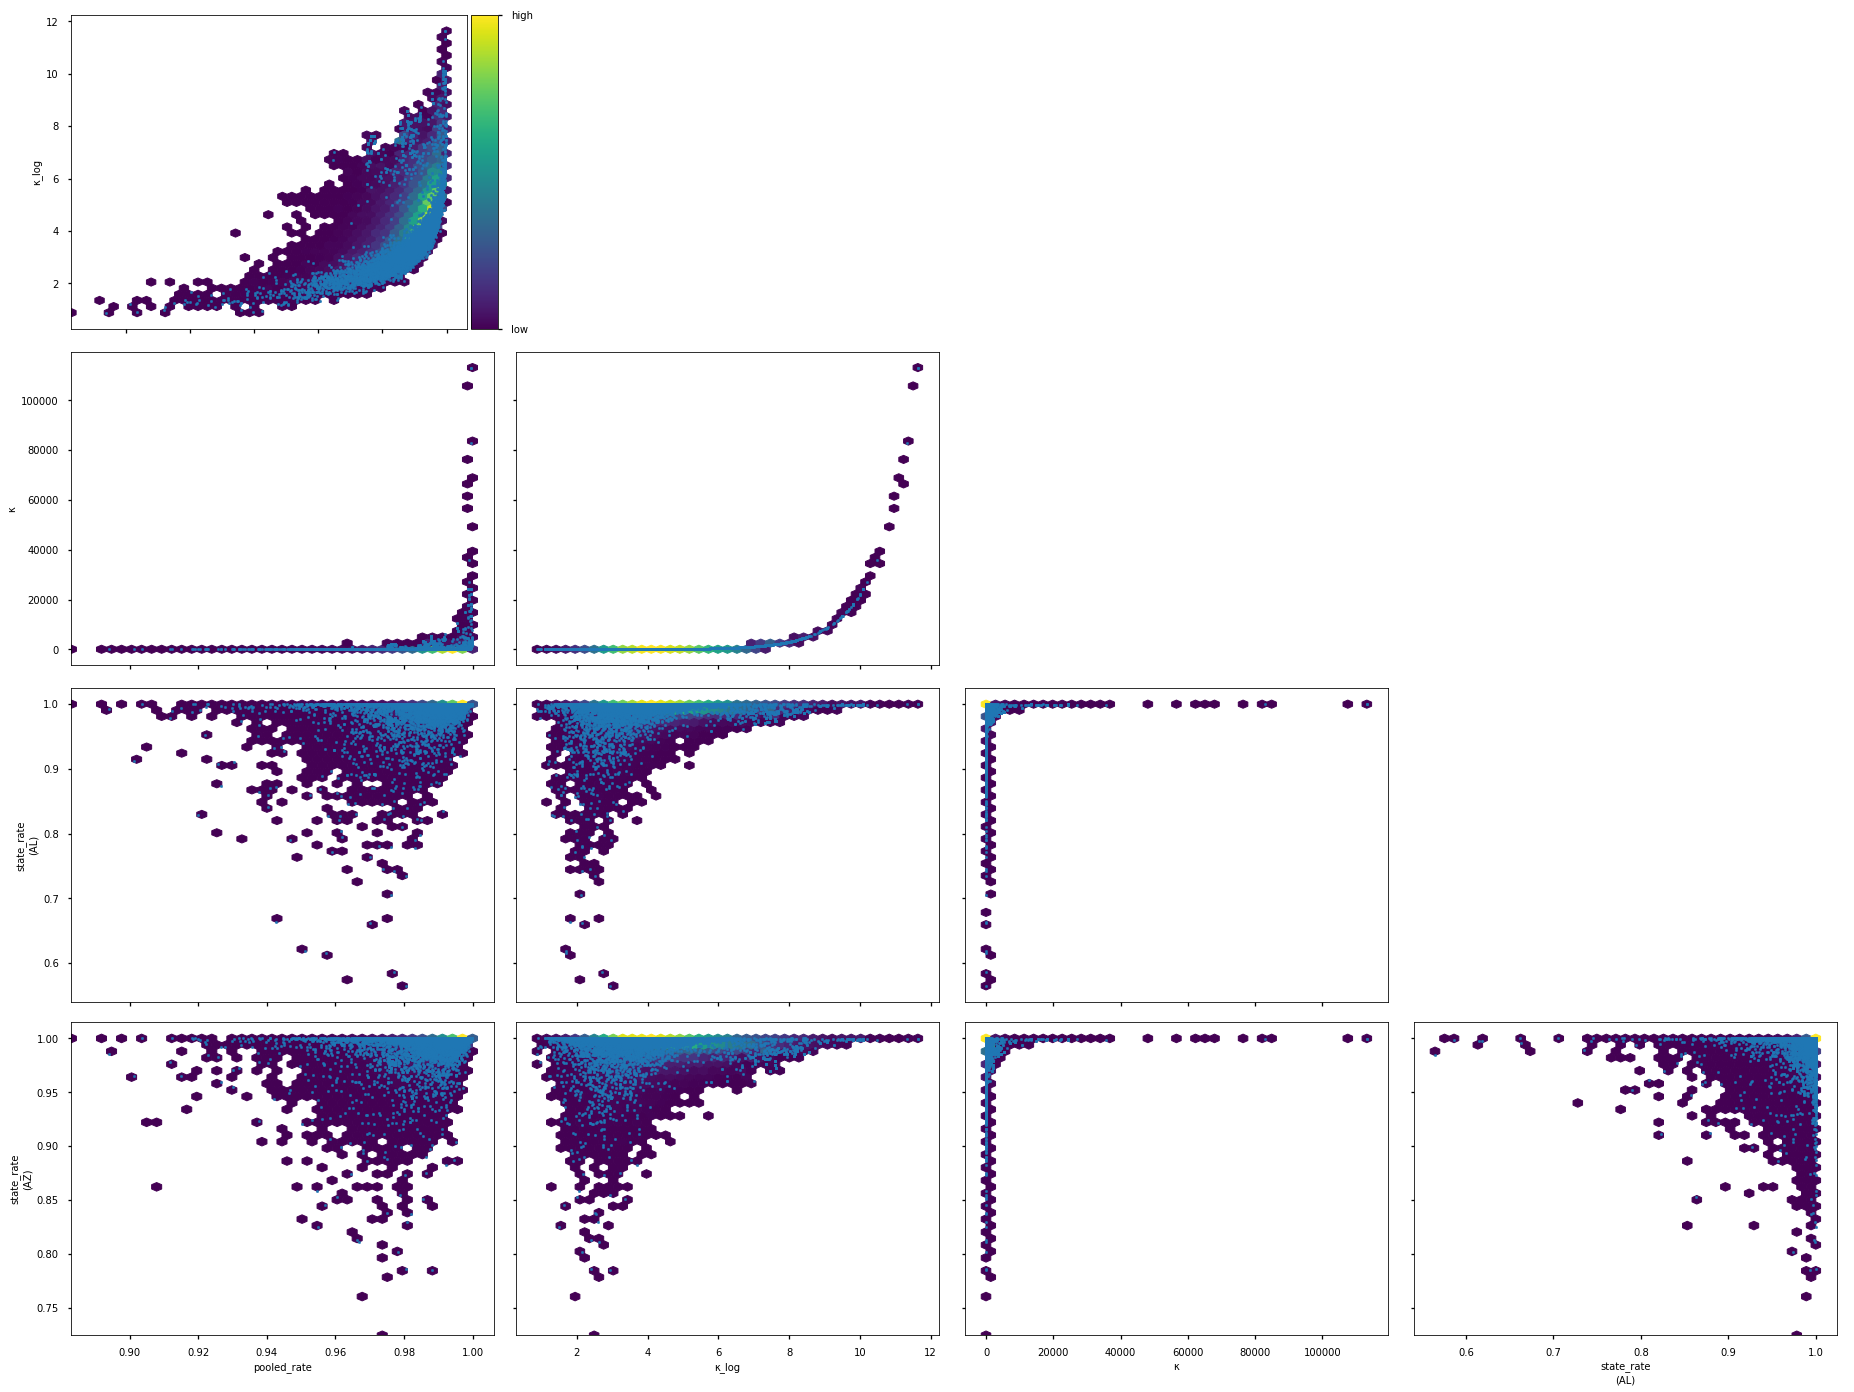

In [33]:
coords = {'state': ['AL', 'AZ']}
az.plot_pair(data, kind='hexbin', coords=coords,
             colorbar=True, divergences=True)

We see quite a lot of divergences in some of these plots. Which indicates our model is poorly specified. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c318d8048>],
      dtype=object)

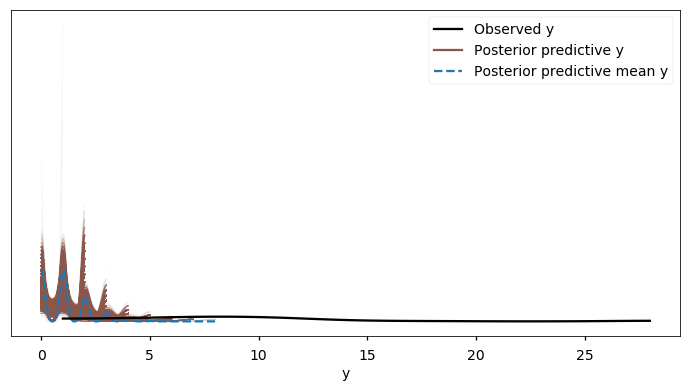

In [34]:
az.plot_ppc(data, alpha=0.03, figsize=(12, 6), textsize=14)


- So what do we see from this plot. 

- Well we see that observed y has a range of about 2 to 30. And we see that our posterior predictive y is bounded between 0 and say 5. 

- This indicates that there's something wrong with our model. We know that Beta will be between 0 and 1, so maybe this has restricted things too much. 


### Let's look at the Beta Distribution
![img](images/Beta_distribution_pdf.svg)

If we look at this distribution here - we'll see the pdf is always bounded between 0 and 1. That makes it a poor choice for our state_rate. We'll switch to Gamma. 

## Gamma distribution
![img](images/Gamma_distribution_pdf.svg)


You can see that the range of Gamma distribution is much wider, so it should be more suitable for our model. 

#  Second model. 
Let's look into the second model. We'll change the state_rate from Beta to 'Gamma'. 

In [35]:
state = df_average.Region.values
def homework_model_revised(hours_of_homework):
    
    with pm.Model() as model:
        pooled_rate = pm.Beta('pooled_rate', alpha=2.0, beta=5.0)
        κ_log = pm.Exponential('κ_log', lam=10)
        κ = pm.Deterministic('κ', tt.exp(κ_log))

        state_rate = pm.Gamma('state_rate', 
                             alpha=pooled_rate*κ, 
                             beta=(1-pooled_rate)*κ, 
                             shape=len(df_average.Region))
        observed_homework = pm.Poisson('y', mu=state_rate, observed=hours_of_homework)

    return model

In [36]:
model_revised = homework_model_revised(hours_of_homework)


In [37]:

print(model_revised.check_test_point())

pooled_rate_logodds__     -0.79
state_rate_log__         -57.51
y                       -637.61
κ_log_log__               -1.06
Name: Log-probability of test_point, dtype: float64


In [38]:
with homework_model_revised(hours_of_homework):
    prior_revised = pm.sample_prior_predictive()
    trace_revised = pm.sample(10000, njobs=4, target_accept=0.90)
    posterior_predictive_revised = pm.sample_ppc(trace_revised)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state_rate, κ_log, pooled_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:53<00:00, 788.83draws/s] 
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/peadarcoyle/miniconda3/envs/ppp/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
100%|██████████| 40000/40000 [00:18<00:00, 2155.91it/s]


/Users/peadarcoyle/miniconda3/envs/ppp/lib/python3.5/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


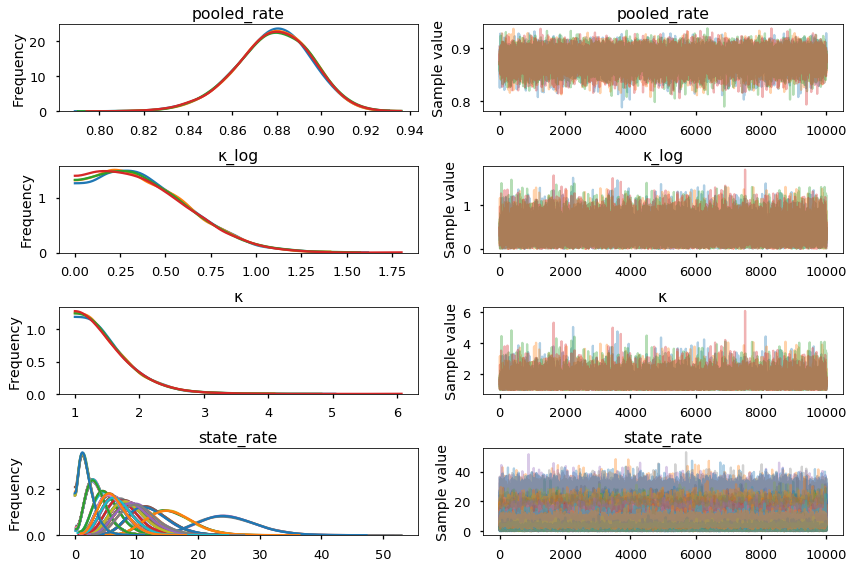

In [39]:
pm.traceplot(trace_revised);


In [40]:
import arviz as az
data_revised = az.from_pymc3(trace=trace_revised,
                     prior=prior_revised,
                     posterior_predictive=posterior_predictive_revised,
                     coords={'state': df_average.Region},
                     dims={'state_rate': ['state']})

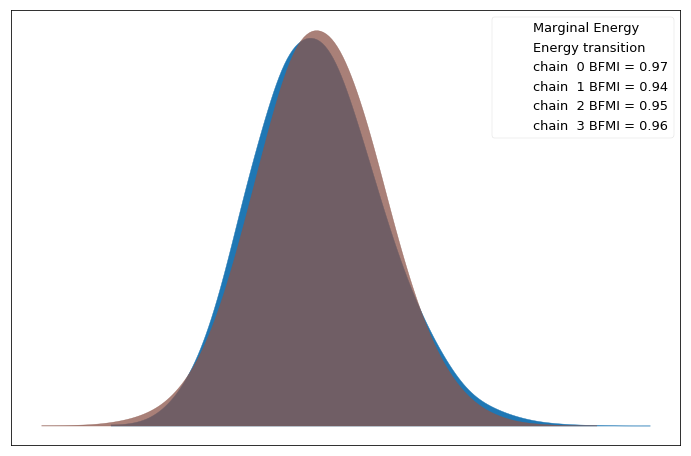

In [42]:
az.plot_energy(data_revised, figsize=(12, 8))

This is much better, our BFMI is much higher, which is good. And our distributions match up well. AWESOME!!!! 

(<matplotlib.axes._subplots.AxesSubplot at 0x1c6860aef0>, GridSpec(4, 4))

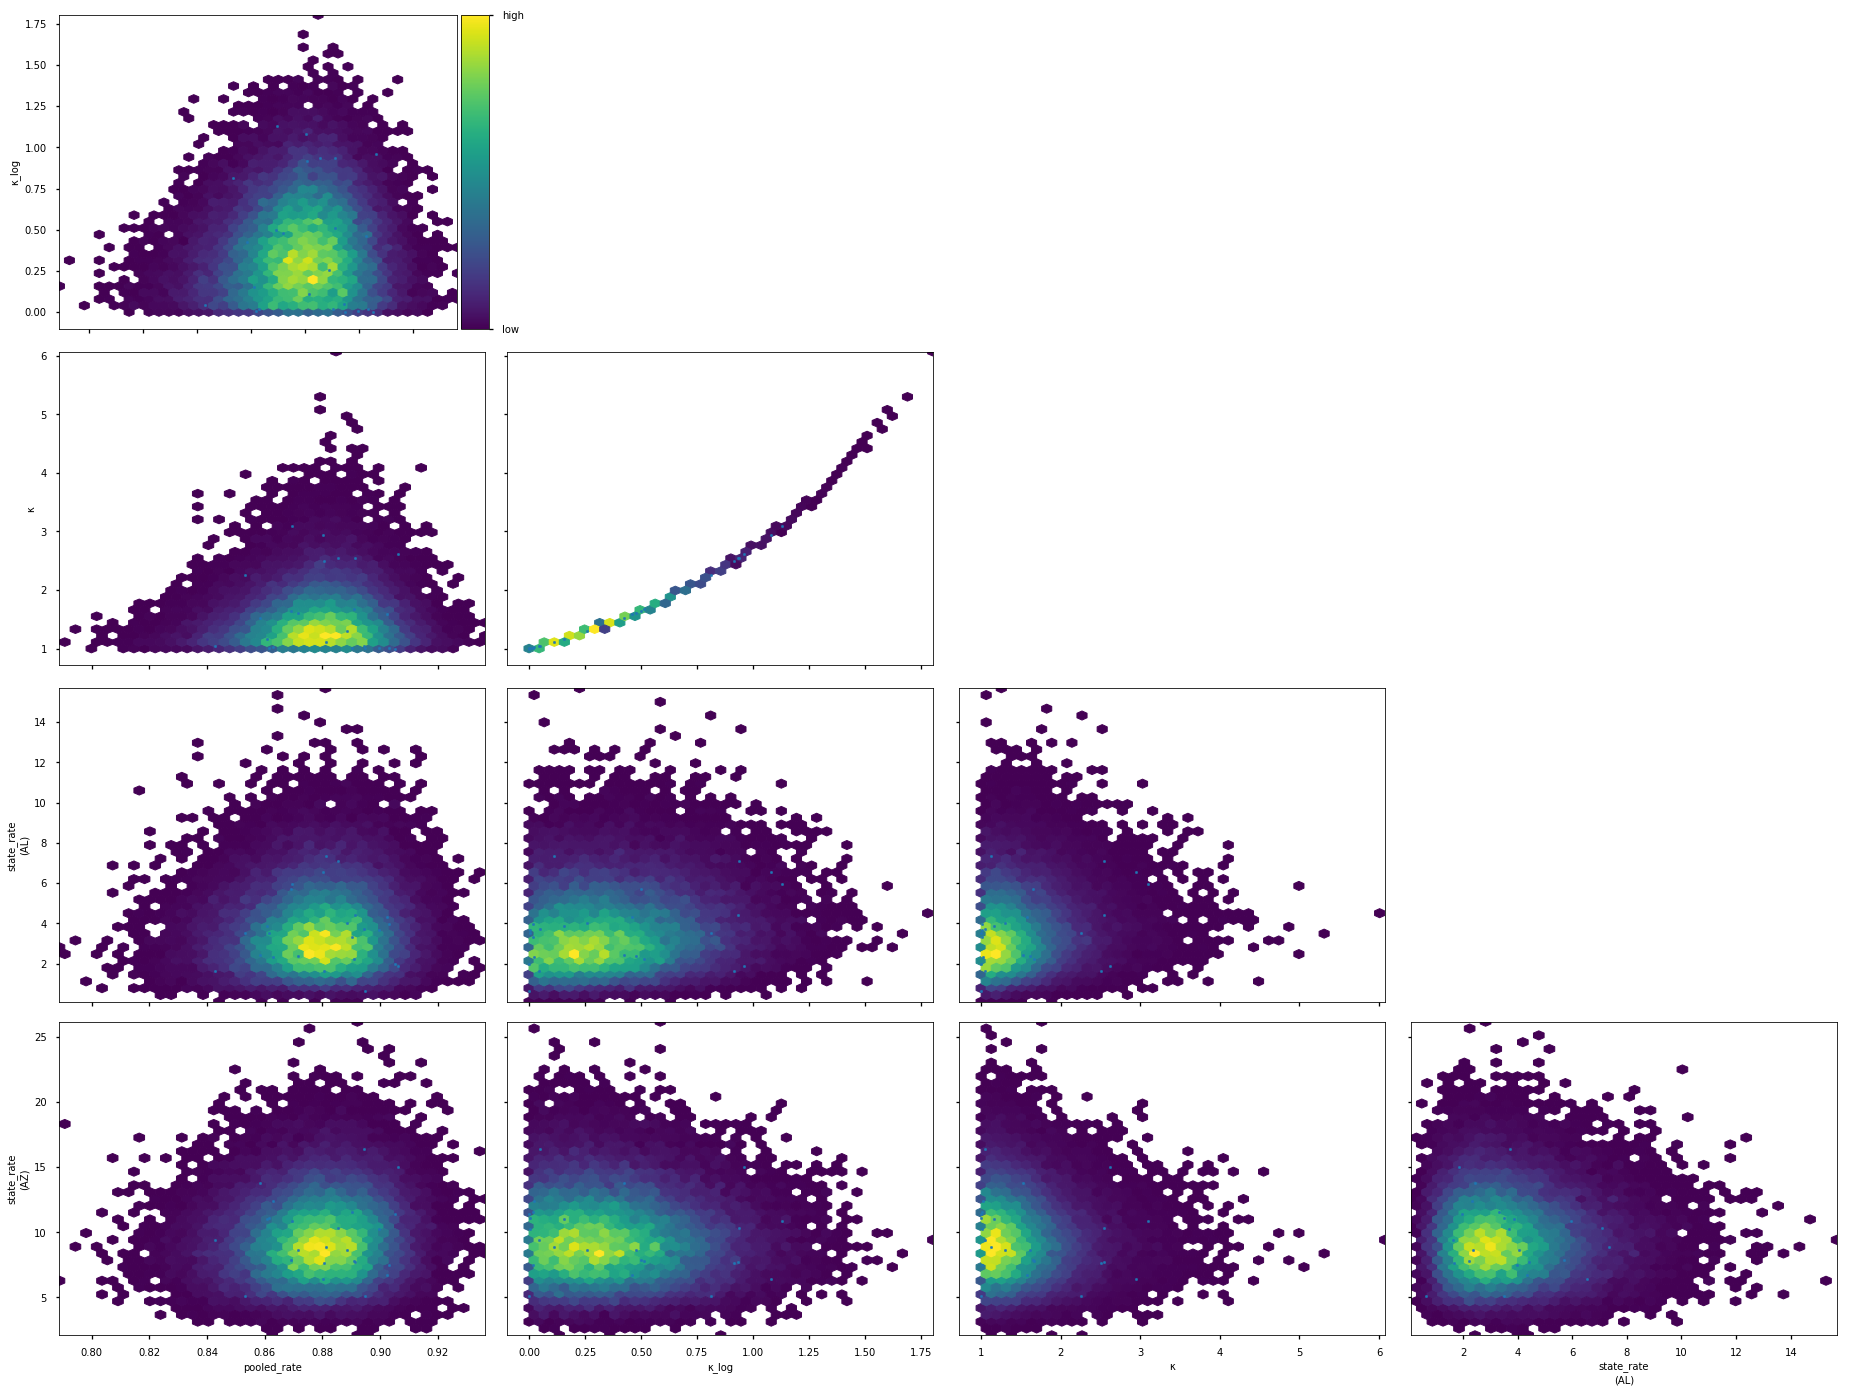

In [44]:
coords = {'state': ['AL', 'AZ']}
az.plot_pair(data_revised, kind='hexbin', coords=coords,
             colorbar=True, divergences=True)

This is a better, plot. It's more spread. 

## Let's look at the ppc plot. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c6872abe0>],
      dtype=object)

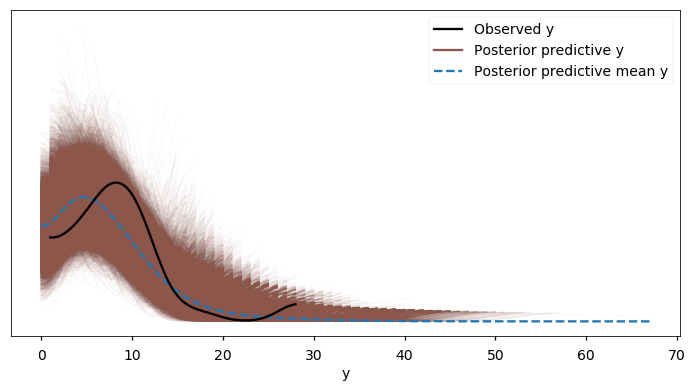

In [45]:
az.plot_ppc(data_revised, alpha=0.03, figsize=(12, 6), textsize=14)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c359806a0>],
      dtype=object)

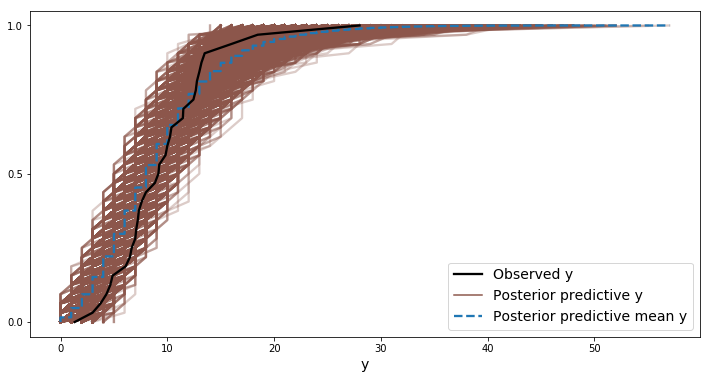

In [36]:
az.plot_ppc(data_revised, alpha=0.3, kind='cumulative', figsize=(12, 6), textsize=14)


(<Figure size 576x2376 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c8061feb8>,
       dtype=object))

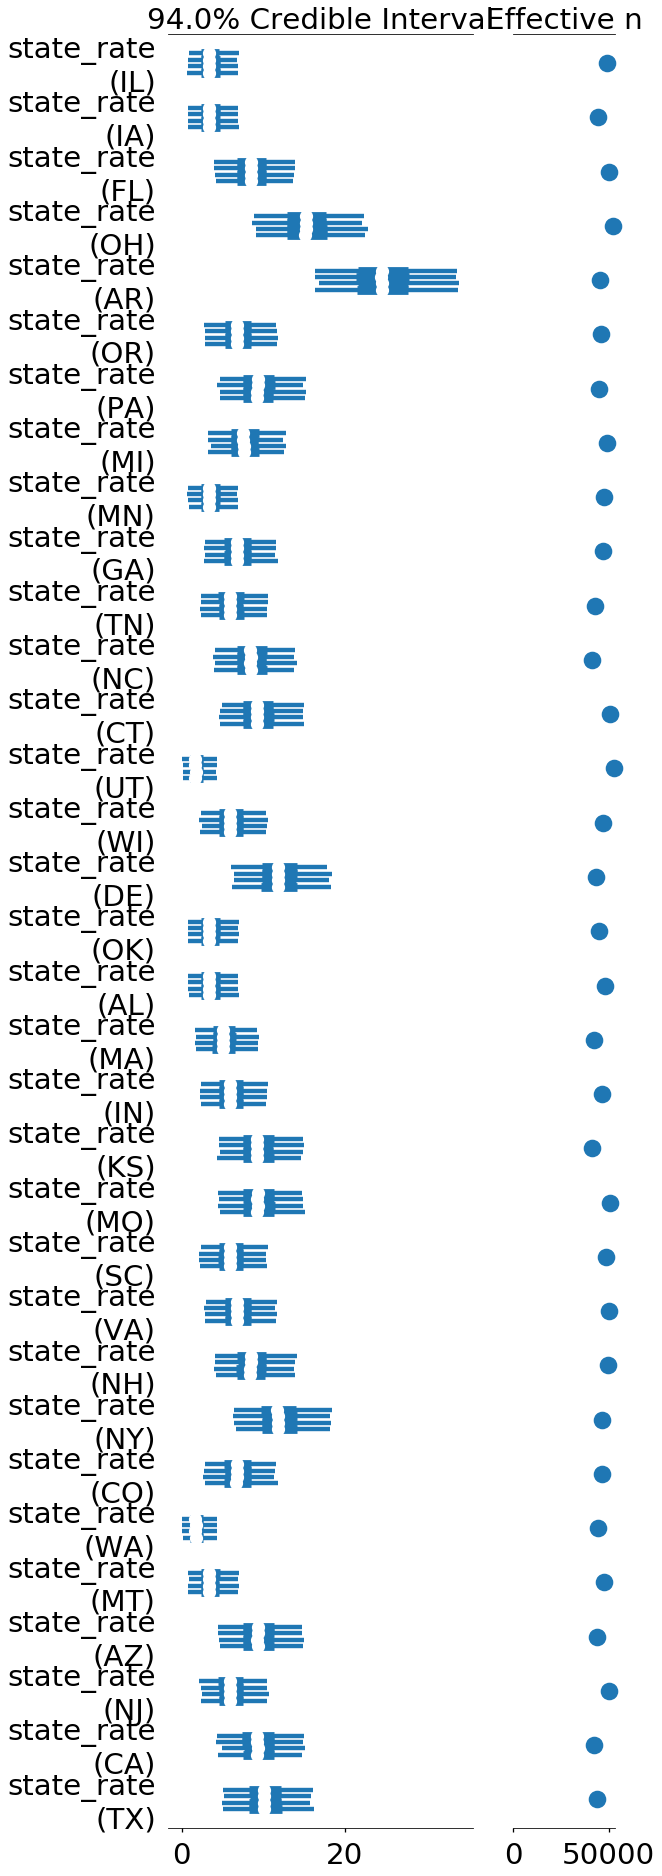

In [46]:
az.plot_forest(data_revised, r_hat=None, var_names=['state_rate'])

### Analysis
* In Colorado, the average predicted homework is something like 7 hours, whereas in Arkansas (AR) it's about 25. 

We can also say that there's a significant difference betwen Arkansas and Colorado. In Missouri - it seems to be something like 9 hours per week. Ohio (OH) has somehting like 18 hours predicted per week. 

Notice also that the HPD - for Arkansas is very wide, it's going from somewhere like 15 - 30. So we're a lot less certain on this estimate. 

/Users/peadarcoyle/miniconda3/envs/ppp/lib/python3.5/site-packages/matplotlib/axes/_base.py:3122: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/Users/peadarcoyle/miniconda3/envs/ppp/lib/python3.5/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


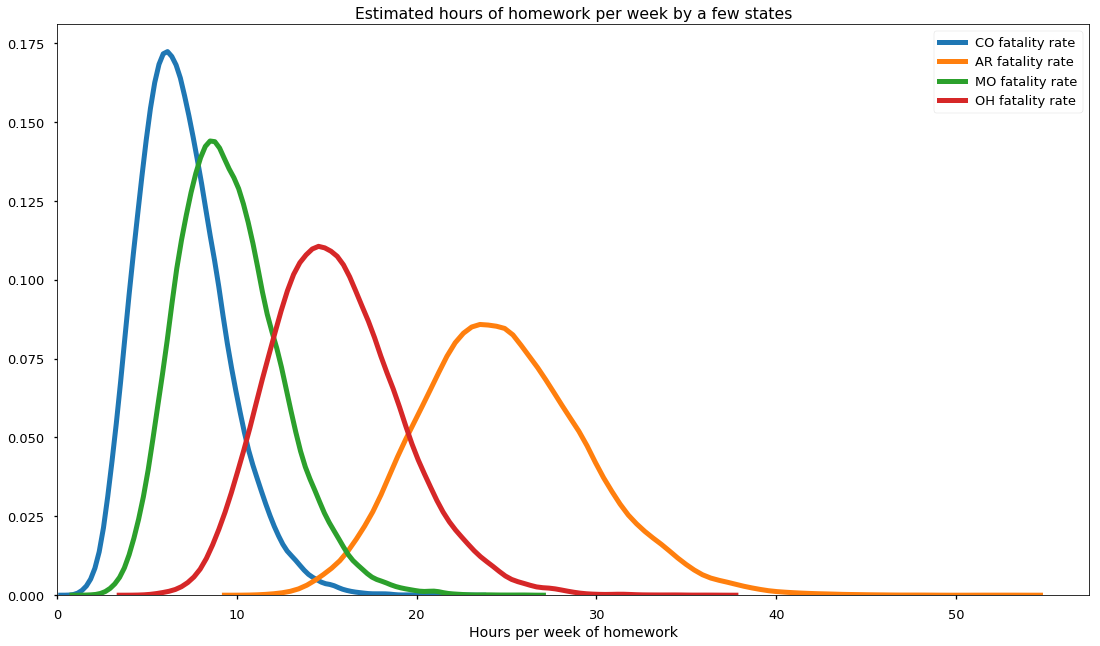

In [47]:

fig, ax = plt.subplots(1, 1)
shared_kwargs = {'hist': False, 'ax': ax, 'kde_kws': {'linewidth': 5}}
for state in ('CO', 'AR', 'MO', 'OH'):
    sns.distplot(trace_revised['state_rate'][:, df_average.Region == state], label='{} fatality rate'.format(state), **shared_kwargs)
fig.set_size_inches(18.5, 10.5)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_title('Estimated hours of homework per week by a few states')
ax.set_xlabel('Hours per week of homework')

ax.legend();

We can see that we have a decent estimate for Colorado, but we really need more data to have better estimates. We can also see from this that it's clear that Arkansas has more homework than Colorado, but it's not clear what the difference is between Ohio and Missouri.  

### What have we seen?
We've seen two models built, and we saw the first one was a poor model due to picking the wrong distribution, we then saw how we could build an improved model. From that improved model we were able to infer new things. 